# UTSA CS 3793/5233: Final Project

Fall 2021


**Najnin - Tanzira - (fsj329)**


## Rubric

**Total Points: 100**

*   (15 + 5 points) Load/Prepare Data + Display 2-3 images
*   (20 points) Model Creation
*   (20 points) Training
*   (10 points) Testing/Evaluation
*   (15 points) Show Loss Curve form Test Dataset(Epoch(X) vs Loss(Y)
*   (15 Points) Plot the Facial Key Points on Images



Nowadays, facial keypoints detection has become a very popular topic and it's applications include Snapchat and other social media application such as realistic avetor . The objective of facial keypoints detection is to find the facial keypoints in a given face, which is very challenging due to very different facial features from person to person. The idea of deep learning has been applied to this problem, such as neural network. After completion of this project, you will understand that a deep neural network can effectively and efficiently solve the facial keypoints detection problem.

**The objective of this task is to predict keypoint positions on face images.**

![alt text](https://github.com/a-oz/Kaggle-Facial-Keypoints-Detection/blob/master/img/pred-compare.png?raw=true "Various Facial Points in Different Images")

From the image you can understand that, given an image, the objective is to predict the dotted points.

## A little introduction to Kaggle

Kaggle, a subsidiary of Google LLC, is an online community of data scientists and machine learning practitioners. Kaggle allows users to find and publish data sets, explore and build models in a web-based data-science environment, work with other data scientists and machine learning engineers, and enter competitions to solve data science challenges.

You can learn more about kaggle from [here](https://www.kaggle.com/).

## Problem Defination

In this problem you will be provided with a dataset from Kaggle. You can dowonload the dataset from [Kaggle](https://www.kaggle.com/c/facial-keypoints-detection/data). Go to the link and click **Download All** at the bottom. **The train dataset has 7049 images and for each of images you will have to predict 15 facial keypoints.** Since each of these points have x and y cordinates, you will have to predict 30 points in total using your model.

### Dataset Descripion

Each predicted keypoint is specified by an (x,y) real-valued pair in the space of pixel indices. There are 15 keypoints, which represent the following elements of the face:

left_eye_center, right_eye_center, left_eye_inner_corner, left_eye_outer_corner, right_eye_inner_corner, right_eye_outer_corner, left_eyebrow_inner_end, left_eyebrow_outer_end, right_eyebrow_inner_end, right_eyebrow_outer_end, nose_tip, mouth_left_corner, mouth_right_corner, mouth_center_top_lip, mouth_center_bottom_lip

Left and right here refers to the point of view of the subject.

In some examples, some of the target keypoint positions are misssing (encoded as missing entries in the csv, i.e., with nothing between two commas).

The input image is given in the last field of the data files, and consists of a list of pixels (ordered by row), as integers in (0,255). The images are 96x96 pixels.

### Data files

training.csv: list of training 7049 images. Each row contains the (x,y) coordinates for 15 keypoints, and image data as row-ordered list of pixels.
test.csv: list of 1783 test images. Each row contains ImageId and image data as row-ordered list of pixels.

### Evaluation of Model
We can not pin-point a particular facial object(e.g. right_eye_center) using a single (x, y) coordinate. A particular facial object can expand a larger region than a single point. For example, we can not pin-point our **left_eye_center** using only one point(x, y). The **left_eye_center** is a combination of multiple points and all of the points are somewhat correct. So if the predicted coordinate is not equal to the ground truth coordinate we cannot say that the prediction is incorrect. So we need a different metric to determine the incorrectness of prediction. One way is to find how far the predicted point is from the ground truth. Thus, we can find out the loss by finding out the root mean square distance between the predicted point(x, y) and the ground truth(x, y).


As you know generally, deep learning problem have 2 categories: Classification and Regression. In classification problem we predict a discrete class label output(e.g Positive or Negative Sentiment). In regression problem we predict a continuous output(e.g Predicting House Prices).

In this problem we are going to predict the POSITION of the keypoints which is a continuous value and not some discrete labels. As a result, our problem is a regression problem.

So, for a regression problem, we need a different loss function. So, when you define the loss function, only use *Root Mean Squared Error (RMSE)* as the loss function. [RMSE Loss from TensorFlow]('https://github.com/tensorflow/tensorflow/blob/091e8500c02ac69c3f1eced6f923598ebfcc354c/tensorflow/python/keras/metrics.py#L2113')

So, how good your model performs, will be evaluated based on how small the loss value is and **not accuracy.**



## Important Notes for Coding

**Use TensorFlow 2.x for this Projecct. Codes with TensorFlow 1.x will not be accepted.**

[Tensorflow 2.x Documentation](https://www.tensorflow.org/api_docs/python/tf)

In [ ]:
#All imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import copy
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow import keras
from google.colab import drive
drive.mount('/content/drive')
print(tf.__version__)

Mounted at /content/drive
2.7.0


## Load/Prepare Data + Display 5 random images:  (15 + 5) points

In [ ]:

# Write your code here
#base path for the files
base_path = '/content/drive/My Drive/Colab Notebooks/FinalProject/'
#reading the traing data
train_data = pd.read_csv(base_path + 'training.csv')
#Converting Image data into float type
train_data['Image'] = train_data['Image'].apply(lambda x: [float(n) for n in x.split(' ')])
#removing nan data from our dataset
no_nan_data = train_data.dropna()

#reshaping the dataset
X = np.vstack(no_nan_data['Image'].values).reshape((-1, 96, 96))
y = no_nan_data.iloc[:, :30].values

#Splitting the dataset into training and testing set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#writing function for pixel  normalization
def normalize_pixels(x_train):
  normed_train = x_train.astype('float32')
  normed_train = normed_train/255.0
  return normed_train

#Normalizing train data
x_train = normalize_pixels(x_train)
#Normalizing test data
x_test = normalize_pixels(x_test)


print("Training data shape: ", x_train.shape, y_train.shape, "\nTesting data shape: ", x_test.shape, y_test.shape)

Training data shape:  (1712, 96, 96) (1712, 30) 
Testing data shape:  (428, 96, 96) (428, 30)


# Adding and reshaping the dataset and augmenting it.


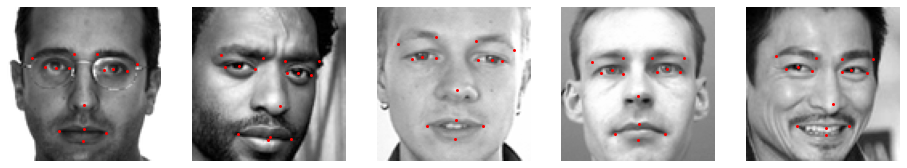

In [ ]:
#Showing random 5 image

#number of random images you want to display
n = 5
indices = random.sample(range(0, x_train.shape[0]), n)
#getting 5 random image
real_images = x_train[indices, :]
real_points = y_train[indices, :]
# Draw 10 images in one row, 10 rows total
plt.figure(figsize=(16,6))
for i in range(len(indices)):
  ax = plt.subplot(1, 5, i+1)
  #showing the images
  ax.imshow(np.squeeze(real_images[i]), cmap='gray')
  #Predicted points
  ax.scatter(real_points[i, ::2], real_points[i, 1::2], marker="o", color="red", s=4)
  ax.axis("off")
plt.show()

## Model Creation: 20 Points

In [ ]:
# Write your code here
#creating the model
model = tf.keras.Sequential([
  # Conv 2D, MaxPool, with optional Dropout
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', input_shape=(96,96,1)),
    tf.keras.layers.MaxPooling2D(pool_size=3),
    tf.keras.layers.Dropout(0.3),
    # Conv 2D, MaxPool, with optional Dropout
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=3),
    tf.keras.layers.LayerNormalization(),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=3),
    # Flatten the layer to feed to Dense layer
    tf.keras.layers.Flatten(),
    # Final Dense layers for classification
    tf.keras.layers.Dense(1000),
    tf.keras.layers.Dropout(0.3),
    # layers.Dense(128, activation='relu'),
    layers.Dense(30)
])
#Printing the model summary
model.summary()
#Printing the model summary
#model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                             
                                                                 
 layer_normalization (LayerN  (None, 10, 10, 128)      2

## Training: 20 Points

In [ ]:
# Write your code here
filepath = '/content/drive/My Drive/Colab Notebooks/FinalProject/facial_keypoints.ckpt'
checkpoint_dir = os.path.dirname(filepath)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath,
                                   monitor='loss',
                                   verbose=0,
                                   save_weights_only=True,
                                   save_best_only=True
                                  )


In [ ]:
#Compiling the model
base_learining_rate = 0.001
model.compile(loss='mse',
                optimizer=tf.keras.optimizers.Adam(base_learining_rate),
              metrics = 'mse')
#number of epochs
epochs = 30
#training the model
history = model.fit(x_train,
                    y_train,
                    epochs = epochs,
                    callbacks=[model_checkpoint_callback])

Epoch 1/30
54/54 [==============================] - 61s 1s/step - loss: 203.5069 - mse: 203.5069
Epoch 2/30
54/54 [==============================] - 60s 1s/step - loss: 35.2523 - mse: 35.2523
Epoch 3/30
54/54 [==============================] - 60s 1s/step - loss: 30.0640 - mse: 30.0640
Epoch 4/30
54/54 [==============================] - 62s 1s/step - loss: 25.2746 - mse: 25.2746
Epoch 5/30
54/54 [==============================] - 60s 1s/step - loss: 23.4012 - mse: 23.4012
Epoch 6/30
54/54 [==============================] - 60s 1s/step - loss: 23.2683 - mse: 23.2683
Epoch 7/30
54/54 [==============================] - 60s 1s/step - loss: 23.5004 - mse: 23.5004
Epoch 8/30
54/54 [==============================] - 60s 1s/step - loss: 20.8092 - mse: 20.8092
Epoch 9/30
54/54 [==============================] - 60s 1s/step - loss: 20.0521 - mse: 20.0521
Epoch 10/30
54/54 [==============================] - 60s 1s/step - loss: 19.1626 - mse: 19.1626
Epoch 11/30
54/54 [============================

In [ ]:
# Re-initialize the model
model = tf.keras.Sequential([
  # Conv 2D, MaxPool, with optional Dropout
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', input_shape=(96,96,1)),
    tf.keras.layers.MaxPooling2D(pool_size=3),
    tf.keras.layers.Dropout(0.3),
    # Conv 2D, MaxPool, with optional Dropout
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=3),
    tf.keras.layers.LayerNormalization(),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=3),
    # Flatten the layer to feed to Dense layer
    tf.keras.layers.Flatten(),
    # Final Dense layers for classification
    tf.keras.layers.Dense(1000),
    tf.keras.layers.Dropout(0.3),
    # layers.Dense(128, activation='relu'),
    layers.Dense(30)
])
# Load the model weights that were saved at - "/content/drive/My Drive/Colab Notebooks/FinalProject/"
checkpoint_filepath = '/content/drive/My Drive/Colab Notebooks/FinalProject/facial_keypoints.ckpt'
model.load_weights(checkpoint_filepath)
base_learining_rate = 0.001
model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(base_learining_rate),
              metrics = 'mse')

## Testing/Evaluation: 10 Points

In [ ]:
# Write your code here
#Evaluating the model on test data
_, loss = model.evaluate(x_test, y_test)
print('Test loss: ', loss)

14/14 [==============================] - 4s 262ms/step - loss: 5.2317 - mse: 5.2317
Test loss:  5.2316694259643555


## Show Loss Curve form Test Dataset(Epoch(X) vs Loss(Y): 15 Points

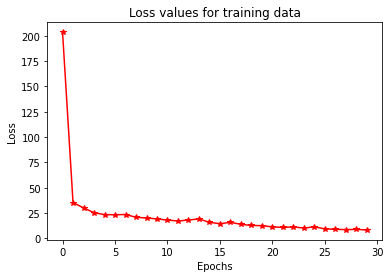

In [ ]:
# Write your code here
#Getting the loss values
loss_values =  history.history['loss']
#Plotting loss values against epochs
plt.plot(range(epochs), loss_values, color = 'r', marker = '*')
plt.title('Loss values for training data')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

## Plot the Facial Key Points on Images: 15 Points

Randomly select 5 Images from Test dataset, Predict 15 facial points for these images. For each image plot the predicted points with red dots and and ground truth points with blue colored dots. So each image should be printed twice, one with predicted points and another with ground truth points.

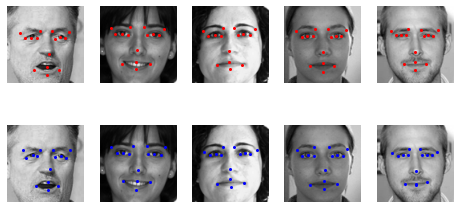

Sample mse: 3.2438


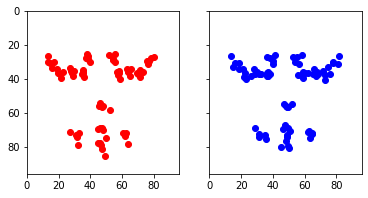

In [ ]:
# Write your code here
#showing 5 random test images
n = 5
indices = random.sample(range(0, x_test.shape[0]), n)

#getting 5 random image
test_images = x_test[indices, :]
#Getting true points for the images and reshaping it
points1 = y_test[indices, :].reshape(len(indices), -1, 2)
#Getting predicted y points
predicted_y_test = model.predict(test_images)
#reshaping the y points
points2 = predicted_y_test.reshape(len(indices), -1, 2)
fig, ax = plt.subplots(2, n, figsize = (8, 4), sharey = True)
# Draw 10 images in one row, 10 rows total
for i, idx in enumerate(indices):
  #showing the images
  ax[0, i].imshow(np.squeeze(test_images[i]), cmap='gray')
  ax[1, i].imshow(np.squeeze(test_images[i]), cmap='gray')
  p1, p2 = points1[i], points2[i]
  #Predicted points
  ax[0, i].scatter(p2[:, 0], p2[:, 1], marker="o", color="red", s=4)
  ax[0, i].set_ylabel('predicted')
  #ground truth
  ax[1, i].scatter(p1[:, 0], p1[:, 1], marker="o", color="blue", s=4)
  ax[1, i].set_ylabel('ground truth')
  ax[0, i].axis("off")
  ax[1, i].axis("off")
plt.show()
fig, ax = plt.subplots(figsize = (6, 3), ncols = 2, sharey = True)
ax[0].scatter(predicted_y_test[:, :-1:2].flatten(), predicted_y_test[:, 1::2].flatten(), c='r')
ax[1].scatter(points1[:, :, 0].flatten(), points1[:, :, 1].flatten(), c='b')
ax[0].set_ylim(top = 0, bottom = 96); ax[0].set_xlim(left = 0, right = 96)
ax[1].set_ylim(top = 0, bottom = 96); ax[1].set_xlim(left = 0, right = 96)
print('Sample mse: {0:0.4f}'.format(((points1 - points2)**2).mean(axis = None)))

# Facial keypoints on Kaggle Test dataset
#### Did this just to check my model on real test dataset.

In [ ]:
#Reading real test dataset provided by kaggle

test_data = pd.read_csv(base_path + 'test.csv')
#Converting Image data into float type
test_data['Image'] = test_data['Image'].apply(lambda x: [float(n) for n in x.split(' ')])
#reshaping the test data
x_real_test = np.vstack(test_data['Image'].values).reshape((-1, 96, 96))
#getting 5 random image

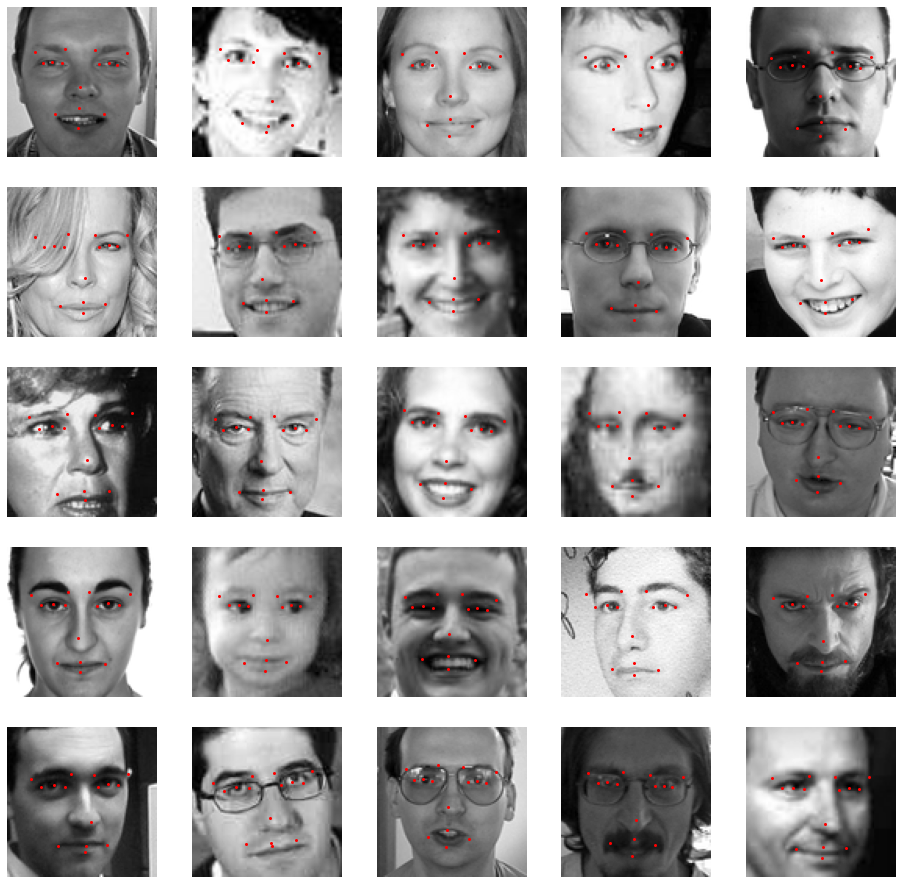

In [ ]:
#Showing random test images
nrow, ncol = 5, 5

#Choosing nrow*ncol random numbers
indices = random.sample(range(0, x_train.shape[0]), nrow*ncol)
test_images = x_real_test[indices, :]

#Getting predicted y points
predicted_y_test= model.predict(test_images)
points =  predicted_y_test.reshape(len(indices), -1, 2)
plt.figure(figsize=(16, 16))
# Draw 10 images in one row, 10 rows total
for i, idx in enumerate(indices):
  ax = plt.subplot(nrow, ncol, i+1)
  #showing the images
  ax.imshow(np.squeeze(test_images[i]), cmap='gray')
  p1= points[i]
  #Predicted points
  ax.scatter(p1[:, 0], p1[:, 1], marker="o", color="red", s=4)
  ax.axis("off")
plt.show()
